## Model Explanation

My initial approach to this problem was to model the difference in voter turnouts in a given state from the prior election" using a Beta PDF with support $[-0.2, 0.2]$ with parameters:

\begin{align}
a &= a_0 + \frac{1}{N} \cdot g(D) \\
b &= b_0 + \frac{1}{N} \cdot h(R)
\end{align}

where:
- $a_0 = b_0 = 12.5$ whose pdf models variance in voter turnout with or without ad spending
- $N$ = total partisan voters in the state
- $D$ = Democratic ad spending (millions of dollars)
- $R$ = Republican ad spending (millions of dollars)

motivated by the fact that ad spending by both parties tended to push the distribution to the center, making the assumption that imbalanced ad spending would cause an advantage for that side.

Also, note that Minnesota was a noise point that was incorrectly written. For the final model I fixed that

## $a_0$ and $b_0$

I needed to choose $a_0$ and $b_0$ such that the generated distribution effectively modeled general trends in the nation with no regards to ad spending. I wanted the parameters to be equal to not give favor to any one party since that would be overfitting to the current data. $12.5$ was a very good choice

Data points in range [-0.2, 0.2]: 204 out of 204


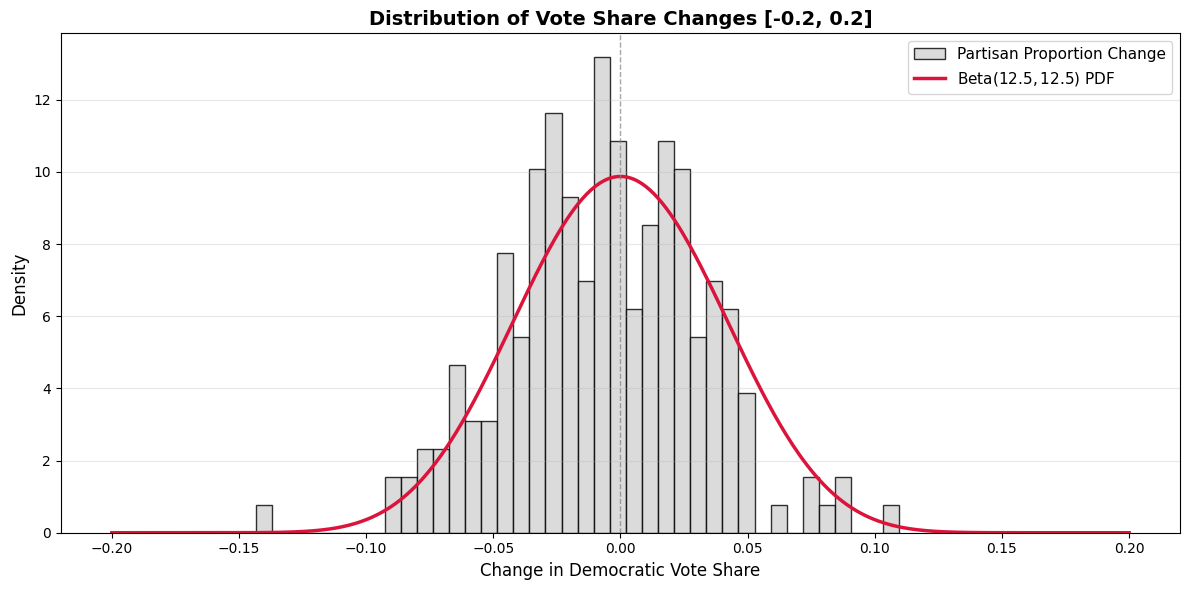

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')

# Calculate Democratic vote share by state and year
state_partisan_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()

state_partisan_votes['DEM_SHARE'] = state_partisan_votes['DEMOCRAT'] / (
    state_partisan_votes['DEMOCRAT'] + state_partisan_votes['REPUBLICAN'])

# Sort by state and year
state_partisan_votes = state_partisan_votes.sort_values(['state', 'year']).reset_index(drop=True)

# Calculate weighted 3-year prior Democratic share
def past_3_inverse_weights(series):
    s = series.shift(1)
    values = np.full(series.shape[0], np.nan)
    weights = np.array([1, 1/2, 1/3])
    for i in range(3, len(s)+1):
        window = s.iloc[i-3:i].values
        if np.isnan(window).any():
            continue
        weighted_avg = np.dot(window, weights) / np.sum(weights)
        values[i-1] = weighted_avg
    return pd.Series(values, index=series.index)

state_partisan_votes['Baseline_DEM_SHARE'] = (
    state_partisan_votes.groupby('state')['DEM_SHARE'].transform(past_3_inverse_weights)
)

# Calculate vote share changes
state_partisan_votes['vote_change'] = state_partisan_votes['DEM_SHARE'] - state_partisan_votes['Baseline_DEM_SHARE']

# Get vote changes (removing NaN values)
vote_changes = state_partisan_votes['vote_change'].dropna().values

# Filter vote_changes to be within [-0.2, 0.2]
filtered_changes = vote_changes[(vote_changes >= -0.2) & (vote_changes <= 0.2)]
print(f"Data points in range [-0.2, 0.2]: {len(filtered_changes)} out of {len(vote_changes)}")

# Prepare x for plotting Beta PDF, mapping support [-0.2, 0.2] to [0, 1]
x_pdf = np.linspace(-0.2, 0.2, 500)
beta_a = 12.5
beta_b = 12.5
x_transformed = (x_pdf + 0.2) / 0.4  # Shift and scale to [0, 1]
beta_pdf = beta.pdf(x_transformed, beta_a, beta_b) / 0.4  # Scale for horizontal stretch

# Plot histogram with Beta PDF overlay
plt.figure(figsize=(12, 6))
plt.hist(filtered_changes, bins=40, density=True, color="lightgray", 
         edgecolor="black", alpha=0.8, label="Partisan Proportion Change")
plt.plot(x_pdf, beta_pdf, color="crimson", linewidth=2.5, label=r"Beta$(12.5,12.5)$ PDF")

plt.xlabel('Change in Democratic Vote Share', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Vote Share Changes [-0.2, 0.2]', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## $g(D)$ and $h(R)$

It is reasonable to assume that spending more money on ads in a state will result in more votes for you. So I chose to only allow $g$ and $h$ to be strictly increasing functions. As such I used basis functions such as $x$, $x^2$, $\log(x + 1)$, or $e^{-x}$. Of these the model was basically decomposing into a linear function.

Number of observations: 40
Turnout change range: [-0.0802, 0.0956]
D spending range: [0.10, 220.00] million
R spending range: [0.20, 128.00] million
Population range: [693,328, 13,932,700] voters
Transformed data range: [0.2995, 0.7390]

FITTING POPULATION-SCALED MODEL (WIDE SUPPORT & QUADRATIC)

OPTIMIZED PARAMETERS

Democratic parameter (a):
  a = 12.5000 + (1/population) * [4.94e+05*D + 1.08e+06*ln(D+1) + 1.58e+03*D^2]

Republican parameter (b):
  b = 12.5000 + (1/population) * [1.17e+06*R + 9.72e+05*ln(R+1) + 0.00e+00*R^2]

Final negative log-likelihood: -36.6487
Optimization success: True

PARAMETER RANGES
a ranges from 12.72 to 40.55
b ranges from 13.08 to 58.34

This is a 27.8 point range for a
and a 45.3 point range for b


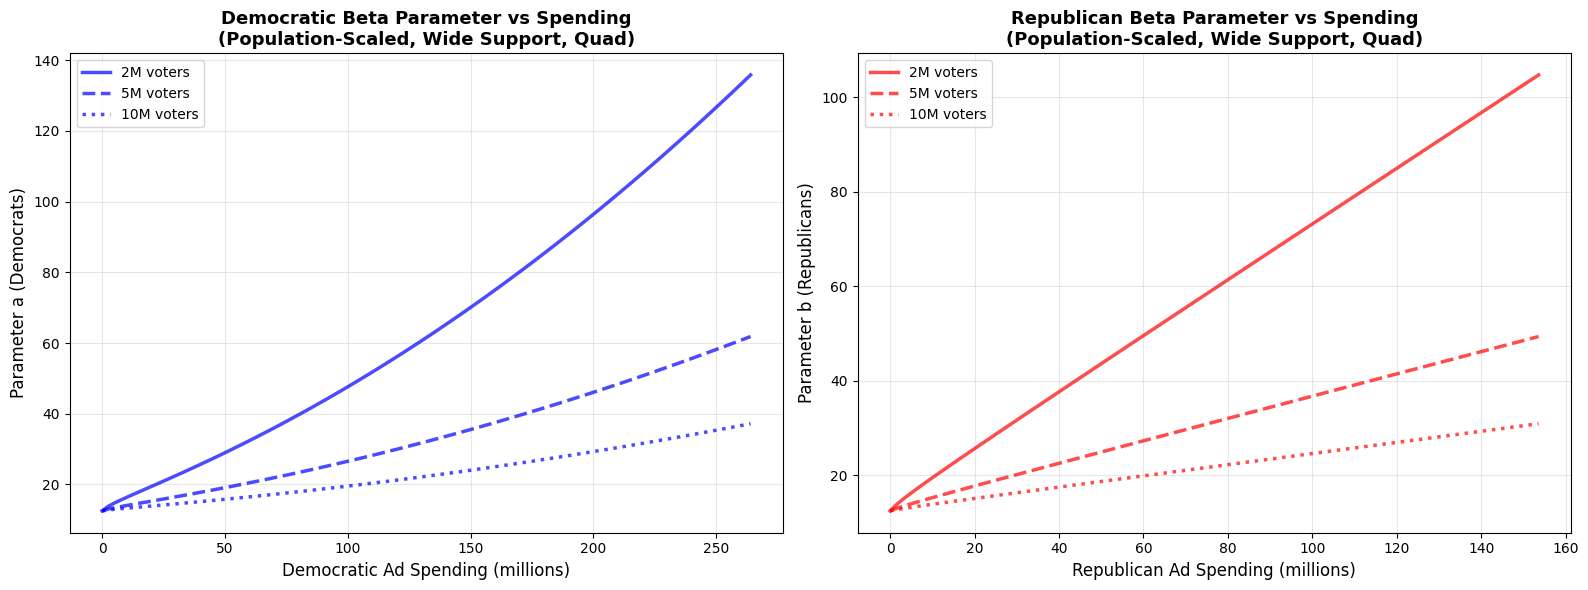

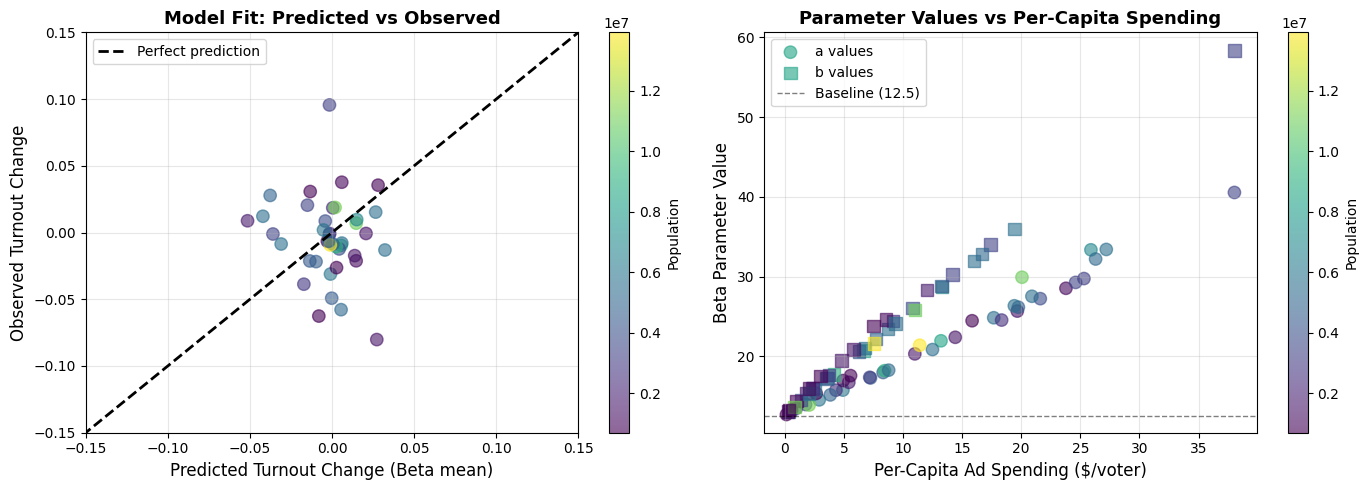

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.optimize import minimize

# Load data
county_df = pd.read_csv('countypres_2000-2024.csv')
ad_df = pd.read_csv('ad_data.csv')

# Get state-level vote counts by year (only DEMOCRAT and REPUBLICAN)
state_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()
state_votes['total_partisan'] = state_votes['DEMOCRAT'] + state_votes['REPUBLICAN']

# Standardize state names for merge
state_votes['state'] = state_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge on year, state to get population
combined_data = ad_df.merge(
    state_votes[['year', 'state', 'total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='inner'
)

# Calculate turnout change (already in [-0.2, 0.2])
combined_data['turnout_change'] = (combined_data['Turnout (D)'] - combined_data['Prior-Turnout (D)']) / 100

# Remove rows with missing data
combined_data = combined_data.dropna(subset=['D-ad-spending', 'R-ad-spending', 'turnout_change', 'total_partisan'])

# Extract arrays just like @file_context_0
D_spending = combined_data['D-ad-spending'].values
R_spending = combined_data['R-ad-spending'].values
turnout_change = combined_data['turnout_change'].values
total_partisan = combined_data['total_partisan'].values

print(f"Number of observations: {len(D_spending)}")
print(f"Turnout change range: [{np.min(turnout_change):.4f}, {np.max(turnout_change):.4f}]")
print(f"D spending range: [{np.min(D_spending):.2f}, {np.max(D_spending):.2f}] million")
print(f"R spending range: [{np.min(R_spending):.2f}, {np.max(R_spending):.2f}] million")
print(f"Population range: [{np.min(total_partisan):,.0f}, {np.max(total_partisan):,.0f}] voters")

# Transform turnout_change to [0, 1] for Beta only internally (for likelihood etc)
lower, upper = -0.2, 0.2
transformed_data = (turnout_change - lower) / (upper - lower)
eps = 1e-7
transformed_data = np.clip(transformed_data, eps, 1 - eps)

print(f"Transformed data range: [{np.min(transformed_data):.4f}, {np.max(transformed_data):.4f}]")

# === MODEL WITH MUCH LARGER PARAMETER SUPPORT AND QUADRATIC TERMS ===

# Population-scaled Beta parameter model with quadratic and super-wide bounds
def g(D, a1, a2, a3):
    # Function of raw spending (millions) for Democrats: linear + log + quadratic
    return a1 * D + a2 * np.log(D + 1) + a3 * D**2

def h(R, b1, b2, b3):
    # Function of raw spending (millions) for Republicans: linear + log + quadratic
    return b1 * R + b2 * np.log(R + 1) + b3 * R**2

# Fixed baseline
a0_fixed = 12.5
b0_fixed = 12.5

def neg_log_likelihood_population_scaled(params):
    # params: a1, a2, a3, b1, b2, b3
    a1, a2, a3, b1, b2, b3 = params
    # ensure positiveness for all terms (quadratic can be negative, but only penalize negatives here)
    if a1 < 0 or a2 < 0 or a3 < 0 or b1 < 0 or b2 < 0 or b3 < 0:
        return 1e12
    a_vals = a0_fixed + (1.0 / total_partisan) * g(D_spending, a1, a2, a3)
    b_vals = b0_fixed + (1.0 / total_partisan) * h(R_spending, b1, b2, b3)
    if np.any(a_vals <= 0) or np.any(b_vals <= 0):
        return 1e12
    ll = np.sum(beta.logpdf(transformed_data, a_vals, b_vals))
    return -ll

# Initial guess: start small but allow optimizer to go big
initial_params = [1e6, 1e6, 0.0, 1e6, 1e6, 0.0]
# Bounds: extend linear and log by 10,000x compared to previous (i.e. 1e12)
widesup = 1e12
bounds = [
    (0, widesup),   # a1: linear term for D spending
    (0, widesup),   # a2: log term for D spending
    (0, widesup),   # a3: quad term for D spending
    (0, widesup),   # b1: linear term for R spending
    (0, widesup),   # b2: log term for R spending
    (0, widesup),   # b3: quad term for R spending
]

print("\n" + "="*60)
print("FITTING POPULATION-SCALED MODEL (WIDE SUPPORT & QUADRATIC)")
print("="*60)

result = minimize(neg_log_likelihood_population_scaled, initial_params, bounds=bounds, method='L-BFGS-B')

a1_opt, a2_opt, a3_opt, b1_opt, b2_opt, b3_opt = result.x
a0_opt = a0_fixed
b0_opt = b0_fixed

print("\n" + "="*60)
print("OPTIMIZED PARAMETERS")
print("="*60)
print(f"\nDemocratic parameter (a):")
print(f"  a = {a0_opt:.4f} + (1/population) * [{a1_opt:.2e}*D + {a2_opt:.2e}*ln(D+1) + {a3_opt:.2e}*D^2]")
print(f"\nRepublican parameter (b):")
print(f"  b = {b0_opt:.4f} + (1/population) * [{b1_opt:.2e}*R + {b2_opt:.2e}*ln(R+1) + {b3_opt:.2e}*R^2]")
print(f"\nFinal negative log-likelihood: {result.fun:.4f}")
print(f"Optimization success: {result.success}")

# Fitted parameter values for observed states
a_fitted = a0_fixed + (1.0 / total_partisan) * g(D_spending, a1_opt, a2_opt, a3_opt)
b_fitted = b0_fixed + (1.0 / total_partisan) * h(R_spending, b1_opt, b2_opt, b3_opt)

print("\n" + "="*60)
print("PARAMETER RANGES")
print("="*60)
print(f"a ranges from {a_fitted.min():.2f} to {a_fitted.max():.2f}")
print(f"b ranges from {b_fitted.min():.2f} to {b_fitted.max():.2f}")
print(f"\nThis is a {a_fitted.max() - a_fitted.min():.1f} point range for a")
print(f"and a {b_fitted.max() - b_fitted.min():.1f} point range for b")

# Visualize the fit for different population sizes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pop_small = 2e6
pop_medium = 5e6
pop_large = 10e6

D_range = np.linspace(0, np.max(D_spending) * 1.2, 100)
R_range = np.linspace(0, np.max(R_spending) * 1.2, 100)

for pop, label, style in [(pop_small, '2M voters', '-'), (pop_medium, '5M voters', '--'), (pop_large, '10M voters', ':')]:
    a_curve = a0_opt + (1.0 / pop) * g(D_range, a1_opt, a2_opt, a3_opt)
    axes[0].plot(D_range, a_curve, linestyle=style, color='b', lw=2.5, label=label, alpha=0.7)
axes[0].set_xlabel('Democratic Ad Spending (millions)', fontsize=12)
axes[0].set_ylabel('Parameter a (Democrats)', fontsize=12)
axes[0].set_title('Democratic Beta Parameter vs Spending\n(Population-Scaled, Wide Support, Quad)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for pop, label, style in [(pop_small, '2M voters', '-'), (pop_medium, '5M voters', '--'), (pop_large, '10M voters', ':')]:
    b_curve = b0_opt + (1.0 / pop) * h(R_range, b1_opt, b2_opt, b3_opt)
    axes[1].plot(R_range, b_curve, linestyle=style, color='r', lw=2.5, label=label, alpha=0.7)
axes[1].set_xlabel('Republican Ad Spending (millions)', fontsize=12)
axes[1].set_ylabel('Parameter b (Republicans)', fontsize=12)
axes[1].set_title('Republican Beta Parameter vs Spending\n(Population-Scaled, Wide Support, Quad)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnostic plots: fit vs observed and per-capita spending vs a/b
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Compute predicted mean in the [-0.2, 0.2] range (original units)
predicted_mean_transformed = a_fitted / (a_fitted + b_fitted)
predicted_mean = predicted_mean_transformed * (upper - lower) + lower

axes[0].scatter(predicted_mean, turnout_change, alpha=0.6, s=80, c=total_partisan, cmap='viridis')
axes[0].plot([-0.2, 0.2], [-0.2, 0.2], 'k--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Predicted Turnout Change (Beta mean)', fontsize=12)
axes[0].set_ylabel('Observed Turnout Change', fontsize=12)
axes[0].set_title('Model Fit: Predicted vs Observed', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(-0.15, 0.15)
axes[0].set_ylim(-0.15, 0.15)
cbar0 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar0.set_label('Population', fontsize=10)

D_per_capita = D_spending * 1e6 / total_partisan
R_per_capita = R_spending * 1e6 / total_partisan

sc = axes[1].scatter(D_per_capita, a_fitted, alpha=0.6, s=80, c=total_partisan, cmap='viridis', label='a values')
axes[1].scatter(R_per_capita, b_fitted, alpha=0.6, s=80, c=total_partisan, cmap='viridis', marker='s', label='b values')
axes[1].axhline(y=a0_fixed, color='k', linestyle='--', lw=1, alpha=0.5, label=f'Baseline ({a0_fixed})')
axes[1].set_xlabel('Per-Capita Ad Spending ($/voter)', fontsize=12)
axes[1].set_ylabel('Beta Parameter Value', fontsize=12)
axes[1].set_title('Parameter Values vs Per-Capita Spending', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
cbar1 = plt.colorbar(sc, ax=axes[1])
cbar1.set_label('Population', fontsize=10)

plt.tight_layout()
plt.show()

## What does this look like?

Here were the results on the states for which I had spending info on

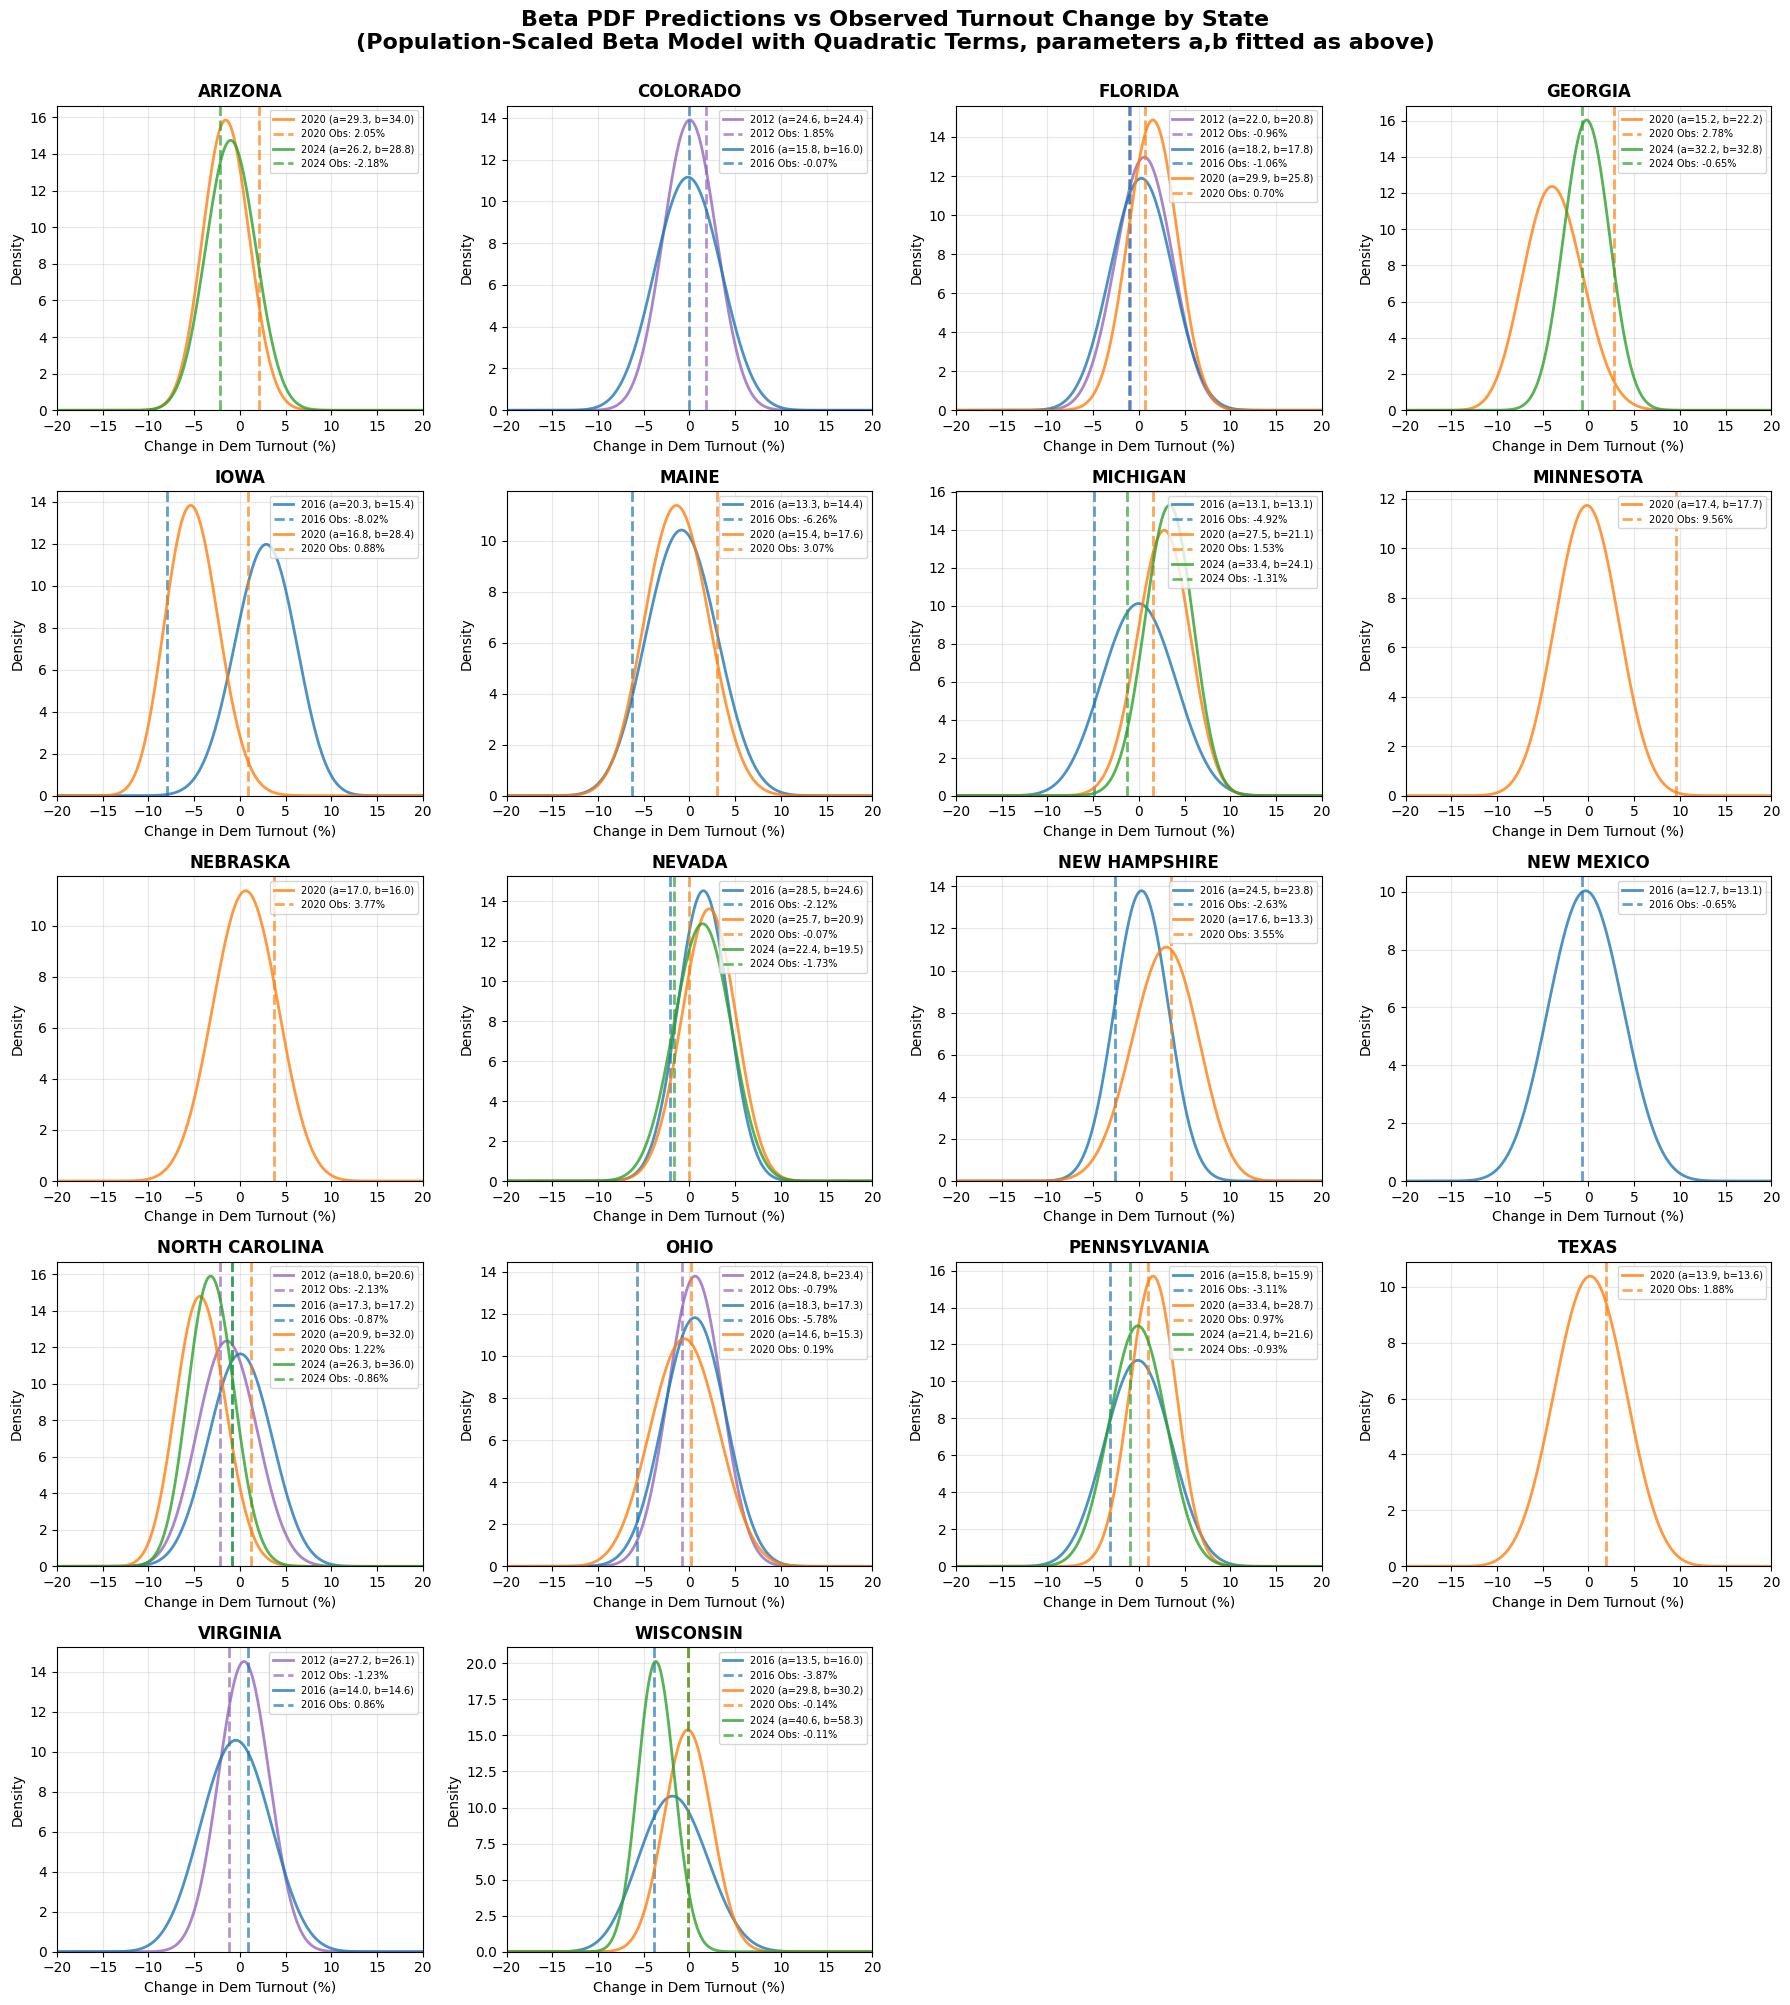


State-Year Summary:
             State  year  D-ad-spending  R-ad-spending  total_partisan          a          b  Turnout_Change
0          ARIZONA  2020           82.0           58.0         3333829  29.277370  34.018897          0.0205
1          ARIZONA  2024           91.0           61.0         4606287  26.166982  28.845954         -0.0218
2         COLORADO  2012           46.0           23.0         2508048  24.557065  24.448302          0.0185
3         COLORADO  2016           11.0            6.0         2541354  15.770461  16.003484         -0.0007
4          FLORIDA  2012          111.0           56.0         8401203  21.955652  20.757117         -0.0096
5          FLORIDA  2016           77.0           38.0         9122861  18.215045  17.757897         -0.0106
6          FLORIDA  2020          220.0          121.0        10965776  29.925543  25.820026          0.0070
7          GEORGIA  2020           19.0           38.0         4936344  15.173382  22.217124          0.027

In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# === Model from file_context_0, now extended ===
# a = a0_fixed + (1.0 / population) * g(D, a1, a2, a3)
# b = b0_fixed + (1.0 / population) * h(R, b1, b2, b3)
# g(D, a1, a2, a3) = a1 * D + a2 * np.log(D + 1) + a3 * D^2
# h(R, b1, b2, b3) = b1 * R + b2 * np.log(R + 1) + b3 * R^2
a0_opt = 12.5
b0_opt = 12.5

# Use actual optimized values from above
a1_opt = a1_opt
a2_opt = a2_opt
a3_opt = a3_opt
b1_opt = b1_opt
b2_opt = b2_opt
b3_opt = b3_opt

# --- Load data ---
ad_df = pd.read_csv('ad_data.csv')
county_df = pd.read_csv('countypres_2000-2024.csv')

# State-level vote counts for each year ('DEMOCRAT'/'REPUBLICAN' only)
state_votes = county_df[county_df['party'].isin(['DEMOCRAT', 'REPUBLICAN'])].groupby(
    ['year', 'state', 'party']
)['candidatevotes'].sum().unstack(fill_value=0).reset_index()
state_votes['total_partisan'] = state_votes['DEMOCRAT'] + state_votes['REPUBLICAN']

# Standardize names
state_votes['state'] = state_votes['state'].str.upper()
ad_df['State'] = ad_df['State'].str.upper()

# Merge to get population (total_partisan)
state_data = ad_df.merge(
    state_votes[['year', 'state', 'total_partisan']],
    left_on=['year', 'State'],
    right_on=['year', 'state'],
    how='left'
)

# One row per state-year, keep necessary variables
state_years = state_data[['State', 'year', 'D-ad-spending', 'R-ad-spending',
                          'Turnout (D)', 'Prior-Turnout (D)', 'total_partisan']].drop_duplicates()
state_years = state_years.sort_values(['State', 'year']).reset_index(drop=True)

# Extended g and h with quadratic
def g(D, a1, a2, a3):
    return a1 * D + a2 * np.log(D + 1) + a3 * D**2

def h(R, b1, b2, b3):
    return b1 * R + b2 * np.log(R + 1) + b3 * R**2

# Safe numeric conversion (from millions to millions, already in ad_df)
D = state_years['D-ad-spending'].astype(float).values
R = state_years['R-ad-spending'].astype(float).values
population = state_years['total_partisan'].astype(float).values

# Compute a and b for each state-year using quadratic model
state_years['a'] = a0_opt + (1.0 / population) * g(D, a1_opt, a2_opt, a3_opt)
state_years['b'] = b0_opt + (1.0 / population) * h(R, b1_opt, b2_opt, b3_opt)

# Turnout change in [-0.2, 0.2] (decimal)
state_years['Turnout_Change'] = (state_years['Turnout (D)'] - state_years['Prior-Turnout (D)']) / 100

# Remove rows with NaN turnout changes (e.g., missing Prior-Turnout)
state_years = state_years.dropna(subset=['Turnout_Change', 'a', 'b'])

# State list for plotting
unique_states = sorted(state_years['State'].unique())

n_states = len(unique_states)
n_cols = 4
n_rows = (n_states + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

x_range = np.linspace(-0.2, 0.2, 500)
x_transformed = (x_range + 0.2) / 0.4

# Colors by year
year_colors = {2012: '#9467bd', 2016: '#1f77b4', 2020: '#ff7f0e', 2024: '#2ca02c'}

for idx, state in enumerate(unique_states):
    ax = axes[idx]
    state_entries = state_years[state_years['State'] == state]
    
    for _, row in state_entries.iterrows():
        a_val = row['a']
        b_val = row['b']
        turnout_change = row['Turnout_Change']
        year = int(row['year'])
        color = year_colors.get(year, 'gray')
        
        pdf_vals = beta.pdf(x_transformed, a_val, b_val)
        pdf_vals = pdf_vals / 0.4  # dy/dx for scaling to correct domain
        
        # Plot Beta PDF (predicted)
        ax.plot(x_range * 100, pdf_vals,
                linewidth=2, color=color,
                label=f'{year} (a={a_val:.1f}, b={b_val:.1f})',
                alpha=0.8)
        
        # Overlay observed turnout-change
        ax.axvline(x=turnout_change * 100,
                   linestyle='--', linewidth=2,
                   alpha=0.7, color=color,
                   label=f'{year} Obs: {turnout_change*100:.2f}%')
        
    ax.set_xlim(-20, 20)
    ax.set_ylim(bottom=0)
    ax.set_xlabel('Change in Dem Turnout (%)', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{state}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_states, len(axes)):
    axes[idx].axis('off')

plt.suptitle(
    'Beta PDF Predictions vs Observed Turnout Change by State\n'
    '(Population-Scaled Beta Model with Quadratic Terms, parameters a,b fitted as above)',
    fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Also print a summary table including a, b, population and input spending
print("\nState-Year Summary:")
print(state_years[['State', 'year', 'D-ad-spending', 'R-ad-spending', 'total_partisan', 
                   'a', 'b', 'Turnout_Change']].to_string())

## Key Takeaways

Since we assume that the functions g(D) and h(R) are monotonically increasing our basis functions are limited, so I explored exponential, logarithmic, and monomial basises, but after factoring the population the only term that the model ever seemed to care about was the linear term. This does reflect the philosophy of diminishing returns though as the expected value of the Beta pdf grows logarithmically as you increase the a parameter. 